# Age Estimation and Gender Classification

Train CNN models to estimate a person's age and gender by given a face image.

**Objectives**

Train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch.
- the other is to finetune a pretrained model.

**Dataset**

Models to be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Use the GPU time wisely.**

There is some limit of free GPU usage (ideally less than 12 hours). 
Therefore, three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [ ]:
## Mount the google drive to the notebook

from google.colab import drive
drive.mount('/content/drive/')
from google.colab import drive
drive.mount('/train_val/')

## A train_val/ folder is created by shoosing a subset of 5.000 face images from the UTKFace dataset to train and validate the model
## The shared google drive folder is:
## https://drive.google.com/drive/folders/1UjYRDyo10Fx-Rv91CQl5ZfwF85HiLUX8

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Mounted at /train_val/


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
from IPython.display import SVG

from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split

from IPython.display import Image
import glob
import cv2
import random


from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
import tensorflow

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
my_Path = '/train_val/MyDrive/Images/train_val/'

files = list(glob.glob(my_Path+'*.jpg'))

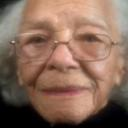

['filename = 100_1_0_20170112215032192.jpg.chip.jpg', 'Age = 100', 'Gender = Female', 'Size = 128 x 128']


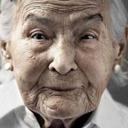

['filename = 100_1_2_20170112213615815.jpg.chip.jpg', 'Age = 100', 'Gender = Female', 'Size = 128 x 128']


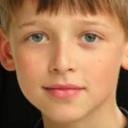

['filename = 10_0_0_20161220222308131.jpg.chip.jpg', 'Age = 10', 'Gender = Male', 'Size = 128 x 128']


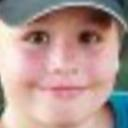

['filename = 10_0_0_20170110220255346.jpg.chip.jpg', 'Age = 10', 'Gender = Male', 'Size = 128 x 128']


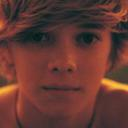

['filename = 10_0_0_20170110220644705.jpg.chip.jpg', 'Age = 10', 'Gender = Male', 'Size = 128 x 128']


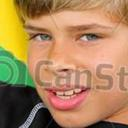

['filename = 10_0_0_20170110221811823.jpg.chip.jpg', 'Age = 10', 'Gender = Male', 'Size = 128 x 128']


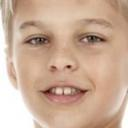

['filename = 10_0_0_20170110224223937.jpg.chip.jpg', 'Age = 10', 'Gender = Male', 'Size = 128 x 128']


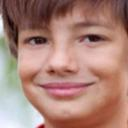

['filename = 10_0_0_20170110224406532.jpg.chip.jpg', 'Age = 10', 'Gender = Male', 'Size = 128 x 128']


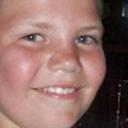

['filename = 10_0_0_20170110225035898.jpg.chip.jpg', 'Age = 10', 'Gender = Male', 'Size = 128 x 128']


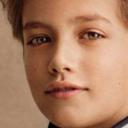

['filename = 10_0_0_20170110225243501.jpg.chip.jpg', 'Age = 10', 'Gender = Male', 'Size = 128 x 128']


In [ ]:
my_Path = '/train_val/MyDrive/Images/train_val/'
file_Infos = []


train_Files = list(glob.glob(my_Path+'*'))

# The function get_fileinfo() takes the image and
# returns the age, gender and size of the image in pixels
# Input : my_Path ( path of the folder )
#         fileName ( the name of the image file )
#
# Output : a list of [filename, age, gender, size ( in Pixel ) ]
#

def get_fileInfo(my_Path, fileName):

  ## remove path from the file name
  replacement = ''
  new_fileName  = fileName.replace(my_Path, replacement)

  ## get the age and gender from the file name
  ageGender    = new_fileName.split('_')[0:2]

  ## get the image size

  img_Size  = cv2.imread(my_Path + new_fileName)
  img_Shape = list(img_Size.shape[0:2])

  if ageGender[1] == '0':
    ageGender[1] = 'Male'
  else:
    ageGender[1] = 'Female'

  file_Info = ['filename = ' + str(new_fileName), 'Age = ' + str(ageGender[0]), \
               'Gender = ' + str(ageGender[1]), 'Size = ' + \
               str(img_Shape[0]) + ' x ' + str(img_Shape[1]) ]

  return file_Info


# This rand_lst is taking 20 random UNIQUE images from files
# which is list of paths of all images

rand_lst = list(random.sample(files, 2))

rand_lst = files[0:10]

# The loop for checking 20 random images with output
# in the format [filename, age, gender, size ( in Pixel ) ]

for random_Image in rand_lst:
  pil_img = Image(filename =random_Image)
  display(pil_img)
  fileName = random_Image.split('/')[-1]

  file_Info  = get_fileInfo(my_Path,fileName )
  print(file_Info)



In [ ]:
# Create an empty DataFrame with 49152 (128*128*3) columns so that
# it can accomodate all the pixels for each individual image

columns = ['p_' + str(i) for i in range(128*128*3)]
columns.extend(['Gender', 'Age'])
df = pd.DataFrame(columns=columns)

In [ ]:


# 1st check if file dataframe.csv exists in the folder
# if it exists, no need to read 5000 images and form the dataframe

# Define the path
dataframes_path = '/train_val/MyDrive/Images/train_val_dataframes/'
file_name = 'combined.csv'

# Check if the file exists in the specified path
file_path = os.path.join(dataframes_path, file_name)
file_exists = os.path.isfile(file_path)

# The Loop takes 5000 image files from the folder
# and then converts the images into pixels by using
# flatten method and store the pixels in the dataframe
# which was created just before ( df )

if file_exists:
    df = pd.read_csv(dataframes_path + 'combined.csv')
# If the read dataframe has any extra unnecessary columns, delete it
    try: df = df.drop(['Unnamed: 0'], axis = 1)
    except: pass

else:
    for i, f in enumerate(files):
        img = cv2.imread(f)
        img = list(img.flatten())

        fname = f.split('/')[-1]

        ageGender = fname.split('_')[0:2]
        age = ageGender[0]
        gender = ageGender[1]
        img.extend([gender, age])
        df.loc[i] = img


# The dataframe would be saved in the folder dataframes_path
        with open(dataframes_path + str('combined.csv'), 'w') as f:
            df.to_csv(f)


## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
# Define image dimensions

image_rows = 128
image_cols = 128
batch_size = 4096

# Separate features (X) and target labels (y) for gender classification

X   = df.drop(['Age', 'Gender'], axis = 1)
y = df['Gender']

# Split data into training and testing sets for gender classification

X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# Separate target labels (y) for age estimation

y = df['Age']

# Split data into training and testing sets for age estimation

X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# Define the image shape

image_shape = (image_rows,image_cols,3)

# Convert training and testing data to numpy arrays

train_data = np.array(X_train, dtype = 'float32')
test_data = np.array(X_test, dtype='float32')

# Reshape data to include image dimensions

train_data = train_data.reshape(train_data.shape[0],*image_shape)
test_data = test_data.reshape(test_data.shape[0],*image_shape)


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

In [ ]:
# Normalize pixel values to the range 0-1

x_train = train_data/255
x_test= test_data/255

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting.

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [ ]:
# Multi CNN

# Define the input shape for an RGB image
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

# First convolutional layer with ReLU activation and max pooling

x = Conv2D(96, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)

# Second convolutional layer with ReLU activation and max pooling

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Third convolutional layer with ReLU activation and max pooling

x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output from the convolutional layers

x = Flatten()(x)

# Fully connected layer with ReLU activation and dropout

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Classification output layer with sigmoid activation

classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)

# Regression output layer

regression_output = Dense(1, name='regression_output')(x)

# Create the model with both classification and regression outputs

modelA = Model(inputs=inputs, outputs=[classification_output, regression_output])

# Print the model summary

modelA.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 96)         2688      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 96)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 61, 61, 128)          110720    ['max_pooling2d[0][0]']   

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save_model(your_model_folder+"age_gender_A.h5")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by `modelA.load_model(model_folder+"age_gender_A.h5")`.


[Fine Tuning Notebook](https://colab.research.google.com/drive/1fKaqjBpHCbUz0wN3u2Sqk5FwksKpXnUe)

In [ ]:
# learning_rate=0.00023557 has been chosen from Hyperparameter Tuning Notebook

# Compile the model with Adam optimizer, different loss functions for classification and regression,
# and specific metrics for each output

modelA.compile(optimizer=Adam(learning_rate=0.00023557),
              loss={'classification_output': 'binary_crossentropy', 'regression_output': 'mae'},
              metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})





In [ ]:
# Train the model
# epochs     = 40
# batch_size = 32

history = modelA.fit(x_train, {'classification_output': y_class_train, 'regression_output': y_reg_train},
                    epochs=40, batch_size=32, validation_split=0.2)

# save the model

modelA.save(my_Path+"age_gender_A.h5")

Epoch 1/40
94/94 [==============================] - 52s 540ms/step - loss: 17.9570 - classification_output_loss: 1.0706 - regression_output_loss: 16.8864 - classification_output_accuracy: 0.5350 - regression_output_mae: 16.8864 - val_loss: 15.4928 - val_classification_output_loss: 0.7378 - val_regression_output_loss: 14.7550 - val_classification_output_accuracy: 0.5547 - val_regression_output_mae: 14.7550
Epoch 2/40
94/94 [==============================] - 48s 506ms/step - loss: 15.8804 - classification_output_loss: 0.8264 - regression_output_loss: 15.0540 - classification_output_accuracy: 0.6237 - regression_output_mae: 15.0540 - val_loss: 13.2608 - val_classification_output_loss: 0.5329 - val_regression_output_loss: 12.7279 - val_classification_output_accuracy: 0.7400 - val_regression_output_mae: 12.7279
Epoch 3/40
94/94 [==============================] - 47s 500ms/step - loss: 13.7992 - classification_output_loss: 0.6411 - regression_output_loss: 13.1581 - classification_output_accu

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


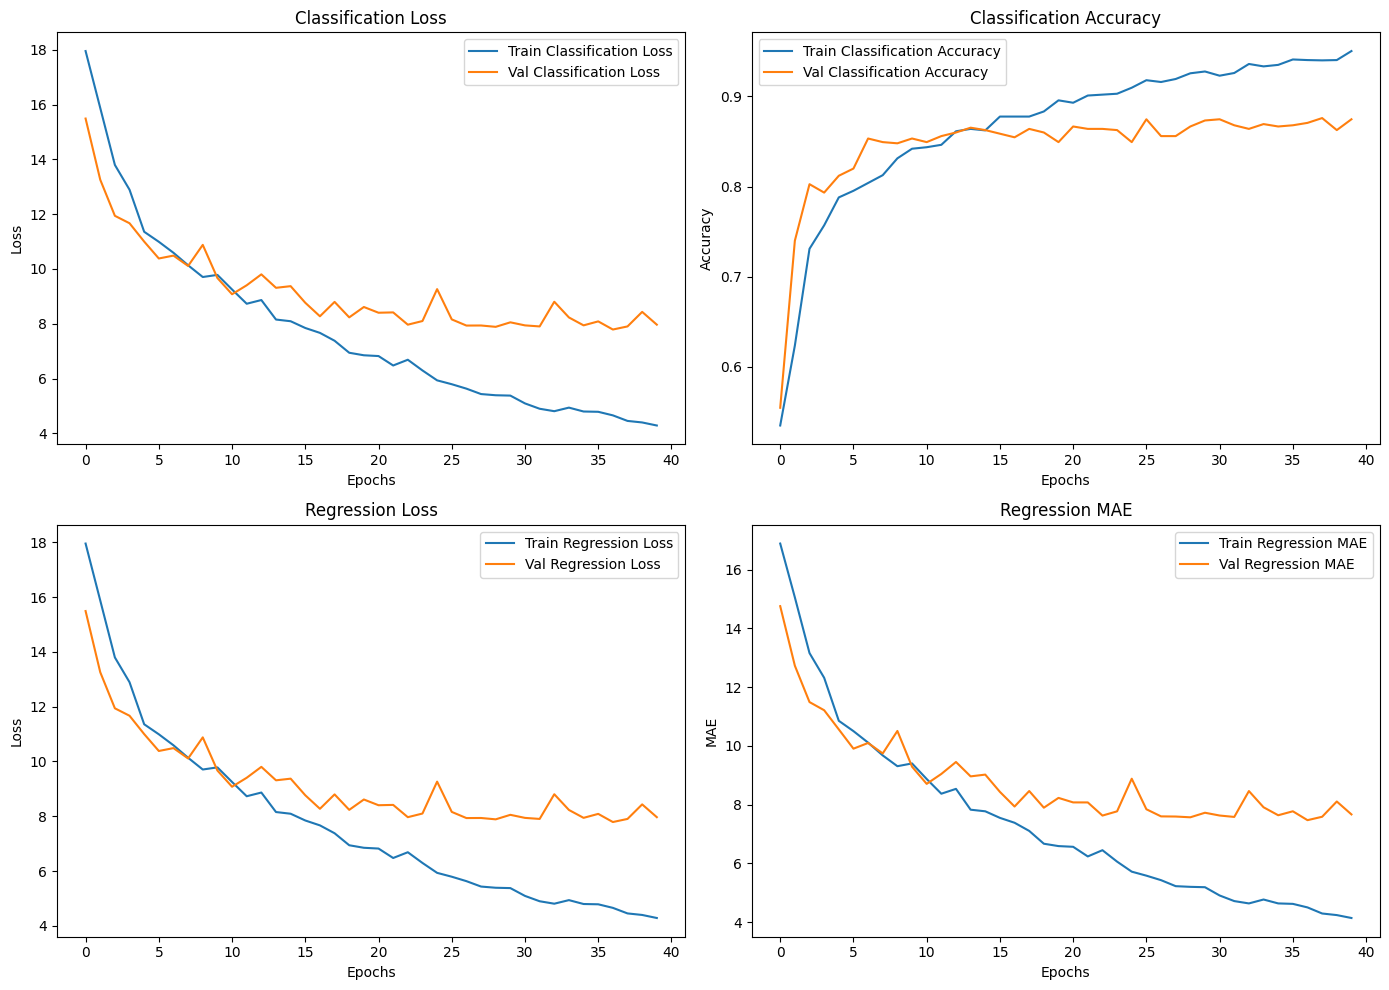

In [ ]:

# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot the loss of the gender classification over the training and validation set
axs[0, 0].plot(history.history['loss'], label='Train Classification Loss')
axs[0, 0].plot(history.history['val_loss'], label='Val Classification Loss')
axs[0, 0].set_title('Classification Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot the accuracy of the gender classification over the training and validation set
axs[0, 1].plot(history.history['classification_output_accuracy'], label='Train Classification Accuracy')
axs[0, 1].plot(history.history['val_classification_output_accuracy'], label='Val Classification Accuracy')
axs[0, 1].set_title('Classification Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Plot the loss of the age estimation over the training and validation set
axs[1, 0].plot(history.history['loss'], label='Train Regression Loss')
axs[1, 0].plot(history.history['val_loss'], label='Val Regression Loss')
axs[1, 0].set_title('Regression Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Plot the MAE of the age estimation over the training and validation set
axs[1, 1].plot(history.history['regression_output_mae'], label='Train Regression MAE')
axs[1, 1].plot(history.history['val_regression_output_mae'], label='Val Regression MAE')
axs[1, 1].set_title('Regression MAE')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()



## STEP2B: Build a CNN network based on a pre-trained model
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [ ]:
# Load Pre-trained ResNet50 Model

from tensorflow.keras.applications import ResNet50
from keras.utils import plot_model

# Load ResNet50 pre-trained on ImageNet without the top layers, with input shape 128x128x3

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


# Create input layer
inputs = Input(shape=(128, 128, 3))

# Pass the inputs through the base model
x = base_model(inputs, training=False)
x = Flatten()(x)

# Classification for gender classification
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)

# Regression for age estimation
regression_output = Dense(1, name='regression_output')(x)

# Create the multi-output model
modelB = Model(inputs=inputs, outputs=[classification_output, regression_output])


# Print model summary

modelB.summary()

# Plot the model architecture

plot_model(modelB, show_shapes=True)

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 4, 4, 2048)           2358771   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 flatten_1 (Flatten)         (None, 32768)                0         ['resnet50[0][0]']            
                                                                                                  
 classification_output (Den

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.h5` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [ ]:

# Compile the model with Adam optimizer, binary crossentropy for classification, and mean absolute error for regression

modelB.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'classification_output': 'binary_crossentropy', 'regression_output': 'mae'},
              metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})




# Train the model on training data with separate targets for classification and regression

history = modelB.fit(x_train,
                    {'classification_output': y_class_train, 'regression_output': y_reg_train},
                    epochs=40, batch_size=32, validation_split=0.2)

# Save the trained model

modelB.save(my_Path+"age_gender_B.h5")

Epoch 1/40
94/94 [==============================] - 83s 717ms/step - loss: 16.6922 - classification_output_loss: 0.9623 - regression_output_loss: 15.7298 - classification_output_accuracy: 0.5023 - regression_output_mae: 15.7298 - val_loss: 15.2563 - val_classification_output_loss: 0.7718 - val_regression_output_loss: 14.4846 - val_classification_output_accuracy: 0.4800 - val_regression_output_mae: 14.4846
Epoch 2/40
94/94 [==============================] - 65s 688ms/step - loss: 15.8251 - classification_output_loss: 0.7493 - regression_output_loss: 15.0758 - classification_output_accuracy: 0.4820 - regression_output_mae: 15.0758 - val_loss: 14.6414 - val_classification_output_loss: 0.6920 - val_regression_output_loss: 13.9494 - val_classification_output_accuracy: 0.5200 - val_regression_output_mae: 13.9494
Epoch 3/40
94/94 [==============================] - 64s 685ms/step - loss: 15.7564 - classification_output_loss: 0.7174 - regression_output_loss: 15.0390 - classification_output_accu

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

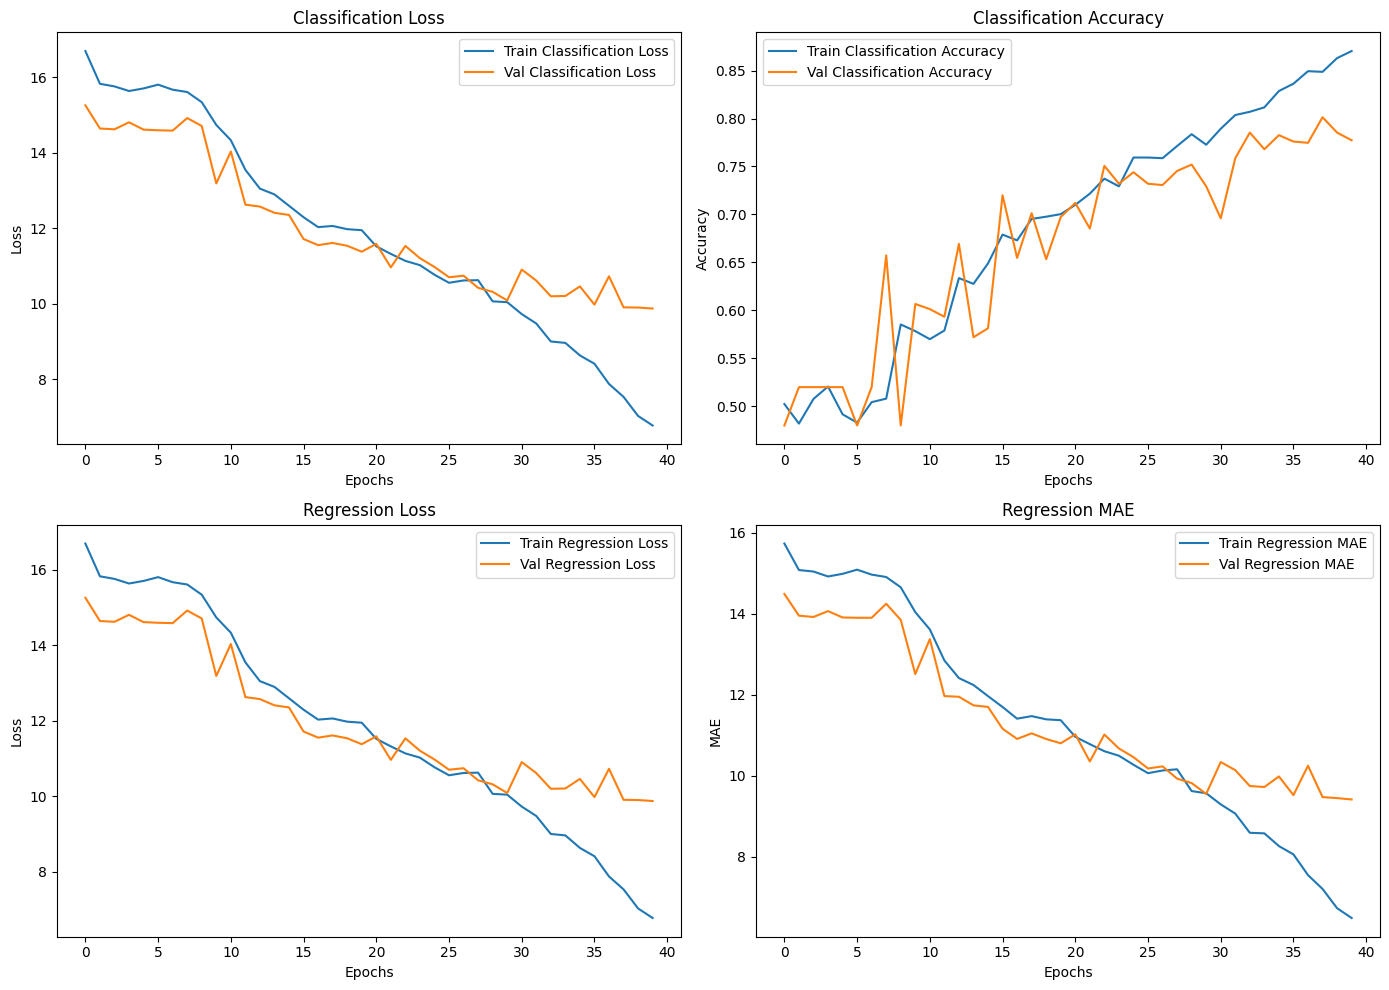

In [ ]:
# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot the loss of the gender classification over the training and validation set
axs[0, 0].plot(history.history['loss'], label='Train Classification Loss')
axs[0, 0].plot(history.history['val_loss'], label='Val Classification Loss')
axs[0, 0].set_title('Classification Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot the accuracy of the gender classification over the training and validation set
axs[0, 1].plot(history.history['classification_output_accuracy'], label='Train Classification Accuracy')
axs[0, 1].plot(history.history['val_classification_output_accuracy'], label='Val Classification Accuracy')
axs[0, 1].set_title('Classification Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Plot the loss of the age estimation over the training and validation set
axs[1, 0].plot(history.history['loss'], label='Train Regression Loss')
axs[1, 0].plot(history.history['val_loss'], label='Val Regression Loss')
axs[1, 0].set_title('Regression Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Plot the MAE of the age estimation over the training and validation set
axs[1, 1].plot(history.history['regression_output_mae'], label='Train Regression MAE')
axs[1, 1].plot(history.history['val_regression_output_mae'], label='Val Regression MAE')
axs[1, 1].set_title('Regression MAE')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()
